<a href="https://colab.research.google.com/github/dellavecchiaemiliano/Derivative-Pricing-with-Monte-Carlo-Lattice-and-PDE-Models/blob/main/Point1_2_3_4_6_5_7_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group 6 Assignment #
## Computational Methods and Machine Learning ##

# Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd
import statsmodels.api as sm
import itertools
from tqdm import tqdm


# Point 1



In this section we first import and then plot the time series of $N+1$ observations of the daily process of the underlying of interest, to infer the behaviour and information on the drift (which is manifestly positive) and clustering. Taking into account that there are 250 trading days, we plot the x-axis in years dividing by 250 the values of the $t$ column from the spreadsheet.


Text(0, 0.5, 'Underlying Price')

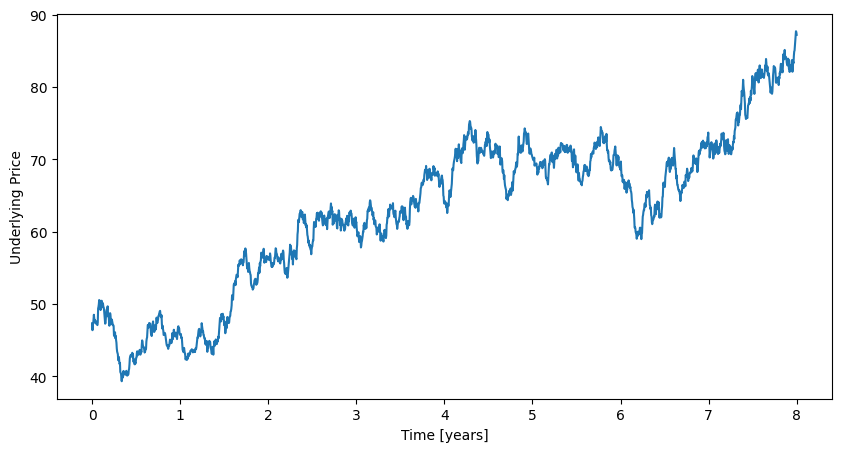

In [ ]:
df = pd.read_excel("Group6_12139_prices.xlsx") #import data

plt.figure(figsize=(10, 5))

# Plot the underlying price time series
plt.plot(df['t'] / 250.0, df['X(t)'])
plt.xlabel("Time [years]")
plt.ylabel("Underlying Price")


<Figure size 1000x500 with 0 Axes>

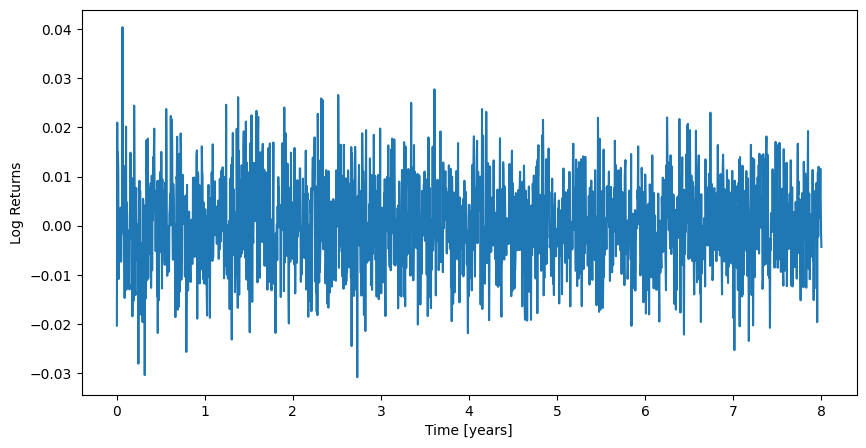

<Figure size 1000x500 with 0 Axes>

In [ ]:
# Plot log returns
df['r'] = np.log(df['X(t)'] / df['X(t)'].shift(1))

# Set figure size
plt.figure(figsize=(10, 5))

plt.plot(df['t'] / 250.0, df['r'])
plt.xlabel("Time [years]")
plt.ylabel("Log Returns")
plt.figure(figsize=(10, 5))

# Point 2


In order to understand if the Brownian motion is an adequate source of randomness for our process, we investigate the normality of the shocks. We write the differential of the Wiener process in terms of the other components of the SDE. We normalise in order to have shocks that can be compared to the standard normal distribution, which has location 0 and scale 1. Last but not least, we translate the SDE in discrete terms by means of the Euler discretization scheme.

<ipython-input-27-76cdcb7757bd>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = df.fillna(method = "ffill")


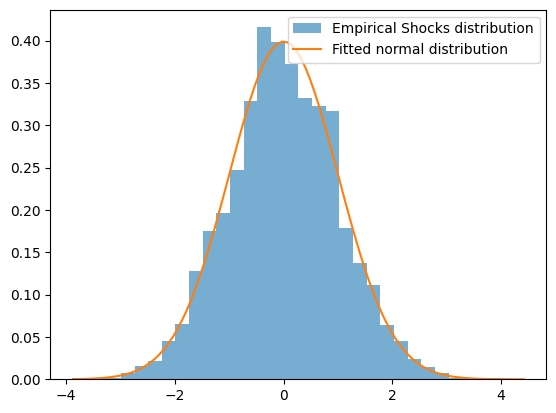

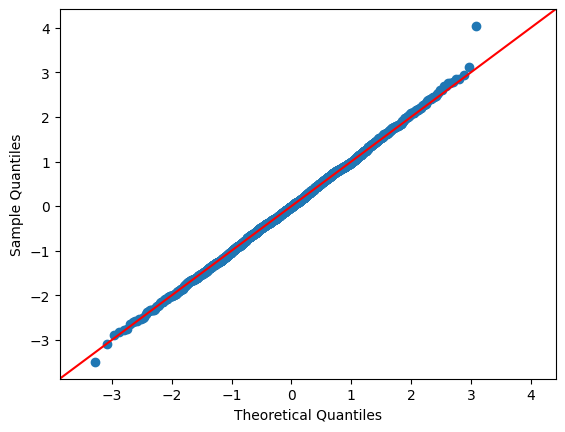

In [ ]:
dt = 1/250 #length of time steps

gamma = 0.39 #Gamma MLE
sigma = 1.1  #Sigma MLE
df["dX"] = (df["X(t)"] - df["X(t)"].shift(1)).shift(-1) #computing returns
df["dW"] = (df["dX"] - df["X(t)"]** gamma * dt) / (sigma * np.sqrt(df["X(t)"])) #computing shocks
df["z"] = df["dW"] / np.sqrt(dt) #normalizing shocks
data = df.fillna(method = "ffill")

#Plot fitting of Normal distribution on empirical distribution
plt.hist(df["z"], bins = 30, density = True, alpha = 0.6, label = "Empirical Shocks distribution")

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0, 1)

plt.plot(x, p, label = "Fitted normal distribution")
plt.legend()
plt.show()

# Q-Q plot
sm.qqplot(df["z"], line = "45")
plt.show()

We conclude that the residuals are normally distributed.

# Point 3

We first define the log MLE function. We iteratively consider the return process and we infer the parameters for the normal distribution, which are the mean and variance of the process. Finally, we fitted the normal distribution to the appropriate parameters.

In [ ]:
def logLikelihoodFunction(parameters, x_t1 , x_t, dt):
    gamma = parameters[0]
    std_mle = parameters[1]
    logLikelihood = -np.sum( np.log( norm.pdf(x_t1, loc = x_t + dt *(x_t**gamma),\
                                              scale = np.sqrt((std_mle**2) * dt *x_t) ) ) )
    return logLikelihood

initialGuess = [0.2, 1]
myBounds = [(0, None), (0, None)]

x_t = np.array(data["X(t)"][:-1]) #from the first to the last-1 obs
x_t1 = np.array(data["X(t)"][1:]) #from the second to the last obs
#since, for each X_t1, I need the previous observation X_t to compute the mean and the std

MLEoutput = minimize(logLikelihoodFunction, initialGuess, args = (x_t1,x_t,dt),\
                          bounds = myBounds, method = 'Nelder-Mead')
gamma_MLE, sigma_MLE = MLEoutput.x
print(f'MLE estimators for gamma and sigma: \n\tGamma={gamma_MLE}\n\tSigma={sigma_MLE}')

MLE estimators for gamma and sigma: 
	Gamma=0.39467411154744364
	Sigma=1.1123423623882396


# Point 4

Now the goal is the pricing of a plain vanilla European call option:
$$\pi_0^E=e^{-rT}E^{Q}[X_T-K]^{+} $$
The first method we used to price the European Call is Montecarlo simulation. We simulated $n$ paths followed by the stock price, to then estimate the relative $n$ different paths followed by the European Call payoff. Then we computed the Montecarlo Estimator, that is the sample mean of the $n$ realizations of the European Call payoffs, and discount it at the risk free rate to get the European Call Option price.

In [ ]:
x0=data['X(t)'].iloc[-1]  #The initial value of the simulation is the last available observation

print(f'\n Initial Value of the simulation: {x0}')
n=10000 #number of Montecarlo simulations we will perform
T=0.5
m = int(T/dt) #monitoring dates that coincides with the steps of a uniform partition of out sample space [0,T]
sigma=np.std(data['X(t)']) #volatility of the data

K=x0 #Strike
r=0.06 #Risk Free Rate
X = np.zeros(shape=(n,m+1))  #We set a nx m+1 matrix of zero
X[:,0] = x0

for i in range(int(n)):
  for j in range(int(m)):
    X[i,j+1] =X[i,j]+((X[i,j]**(gamma_MLE))*dt +sigma_MLE*np.sqrt(X[i,j])*np.sqrt(dt)*np.random.normal(0,1))

X_MC = X
EuCall_T=np.maximum(X_MC[:,-1]-K,0)
EuCall_price=np.exp(-r*T)*np.mean(EuCall_T)
print(f'\n European Call Price: {EuCall_price}')



 Initial Value of the simulation: 87.20820505423303

 European Call Price: 4.510317840218157


<ipython-input-30-5ac63d76ab54>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


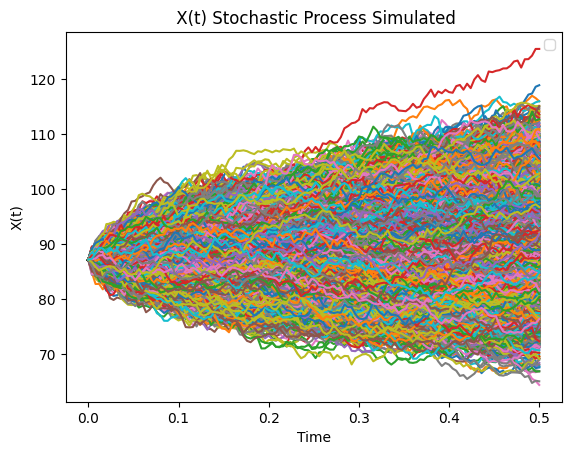

In [ ]:
Time=np.linspace(0,T,m+1)

for i in range(int(n)):
  plt.plot(Time,X[i,:])

plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title(' X(t) Stochastic Process Simulated')
plt.legend()

# Point 5

Here we will price the same European Call option using a lattice techniques. The diffusive coefficient of our process $σ\sqrt{X_t}$ is not constant and, therefore, to set use lattice techniques with processes of this kind we need to do the following thing: First of all, we found an invertible function $f(X)$:
$$f(X) = \int\frac{1}{b(X)}dx = \frac{2}{\sigma}\sqrt{x}$$
whose derivative with resepct to x makes the diffusive coefficient of the stochastic differential of the function $f(X)$ constant. Then, we computed the stochastic differential of $f(X)$, to ensure the diffusive coefficient to be constant ($b_f(X_t)=1$), to then set up a lattice discretization for the transformation $f(X)$ using as increment at each step equal to $1$.

In [ ]:
delta_f=1*np.sqrt(dt) #increments of the function at each step
discFct=np.exp(-r*dt)

X_t_lattice=np.zeros(shape=(m + 1,m + 1))
x0_lattice=(1/sigma_MLE) * 2 * np.sqrt(x0)
q_lattice = np.zeros((int(m + 1), int(m + 1))) # the probability q here is state dependent and, therefore, changes at each node
EuCall_lattice = np.zeros((int(m + 1), int(m + 1)))


for i in range(0,int(m + 1)):
    for j in range(0,int(i + 1)):
        X_t_lattice[j, i] = (x0_lattice + delta_f * (i - j) - delta_f * j)
        X_t_lattice[j, i] = (( X_t_lattice[j, i] * sigma_MLE) / 2  )** 2  # inverse of the function f(x)
        drift_f = (1/sigma_MLE) * X_t_lattice[j, i] ** (gamma_MLE - 1/2) - 1/4 * sigma_MLE * X_t_lattice[j, i] ** ( -1/2 )  # this is the the drift of the stiochastic differential of the function df(t,Xt)
        q_lattice[j, i] = max( 0, min( 1, 0.5 + drift_f * np.sqrt(dt) / 2 ) )

EuCall_lattice[:,-1] = np.maximum(X_t_lattice[:,-1] - K, 0) #final payoff of the Call to then going back recursively
for i in range(int(m)):
  for j in range(int(m - i)):
    EuCall_lattice[j,m-i-1] = discFct*(q_lattice[j,m-i]*EuCall_lattice[j,m-i] + (1-q_lattice[j,m-i])*EuCall_lattice[j+1,m-i])

print(f'European Call Option price using lattice discretization: {EuCall_lattice[0,0]}')
print(f'\n European Call Option price using Monte Carlo simulations: {EuCall_price}')
print(f'The difference between the two prices: {EuCall_price - EuCall_lattice[0,0]}')

European Call Option price using lattice discretization: 4.511546369578028

 European Call Option price using Monte Carlo simulations: 4.510317840218157
The difference between the two prices: -0.0012285293598708336


# Point 6

Computing the price of the option by the numerical solution of the Black and Scholes PDE. The explicit finite differences method is used.

In [ ]:
# Fix the maximum value of the price of the underlying, taking into account that we want the value of x0 to be in the grid
Xmax = 2*x0

# Set the steps for the grid dimensions
nt = 200
nx = 100

# Define the increments for both time and the price of the underlying
dt = T/nt
dx = Xmax/nx

# Define all the nodes of the grid for each dimension
nodest = np.linspace(0,T,nt+1)
nodesX = np.linspace(0,Xmax,nx+1)

# Define the grid
f = np.zeros(shape=(nt+1, nx+1))

# Set the boundary conditions
f[-1,:] = np.maximum(0, nodesX-K)
f[:,0] = 0
f[:,-1] = (nodesX[-1]-K)*np.exp(-r*(T-nodest))

# Compute the value of the derivative at each node using the explicit finite differences method.
# In other words, knowing the payoff of the derative at maturity,
# the price in previous nodes is calculated by a backward recursive approach.
for i in range(nt, 0, -1):
    for j in range(1,nx):
        f[i-1,j] = dt * (  f[i,j-1] * (-((j*dx)**gamma_MLE)/(2*dx) + (sigma_MLE**2 * j)/(2*dx)) \
                         + f[i,j] * (1/dt - (sigma_MLE**2 * j)/(dx) - r) \
                         + f[i,j+1] * (((j*dx)**gamma_MLE)/(2*dx) + (sigma_MLE**2 * j)/(2*dx)))

# Once we have the price of the derivative at each of the grid, we can compute its price at inception.
# To do so, we look for the cell in the matrix that correspons to this value.
# As inception is at time 0, the row we are interested in is the first one.
# For the column index, we look for the one that corresponds to the current spot price x0.
j_star = int(x0/dx)

# Finally, we plot the result
pd.DataFrame(f)
print(f'Call option price by the PDE numerical solution: {f[0,j_star]}')


Call option price by the PDE numerical solution: 4.48824695209094


# Point 7

We price an American call option using a lattice-based approach that allows early exercise. At each time step $t_i$, the holder decides whether to exercise by comparing the **immediate payoff** $f(S_{t_i})$, which represents the option's intrinsic value, and the **continuation value**  

$$
\sup_{\tau \in [t_i, T]} \mathbb{E}^\mathbb{Q} [f(S_{\tau}) \mid \mathcal{F}_{t_i}],
$$

which is the expected discounted payoff if the option is held. The option price is then given by  

$$
\pi_0^A = \max \left( f(S_{t_i}), \sup_{\tau \in [t_i, T]} \mathbb{E}^\mathbb{Q} [f(S_{\tau}) \mid \mathcal{F}_{t_i}] \right).
$$

In the absence of dividends, early exercise is typically suboptimal, and the computed price is  

$$
\pi_0^A = 4.54.
$$

In [ ]:
def price_american_call(X_lattice, K, Q, discfct, numstep, Eu_lattice):
    # Initialize the lattice
    AmCall_lattice = np.zeros_like(X_lattice)

    # Set terminal payoffs
    AmCall_lattice[:, -1] = np.maximum(X_lattice[:, -1] - K, 0)

    # Backward recursion
    for i in reversed(range(int(numstep))):
        for j in range(i + 1):
            IP = max(X_lattice[j, i] - K, 0)  # Immediate Payoff
            CV = discfct * (Q[j, i] * AmCall_lattice[j, i+1] + (1 - Q[j, i]) * AmCall_lattice[j+1, i+1])  # Continuation Value

            # Optimal decision
            AmCall_lattice[j, i] = max(IP, CV)

    # Extract price and exercise premium
    AmCall_price = AmCall_lattice[0, 0]
    exercise_premium = AmCall_price - Eu_lattice[0, 0]

    print(f"Lattice discretization price of the American call option: {AmCall_price}")
    print(f"Exercise Premium: {exercise_premium}")

    return AmCall_price, exercise_premium

# Example usage:
price_american_call(X_t_lattice, K, q_lattice, discFct, m, EuCall_lattice)

Lattice discretization price of the American call option: 4.5126506013045296
Exercise Premium: 0.0011042317265017587


(4.5126506013045296, 0.0011042317265017587)

# Point 8
It is wanted to price an up-and-out barrier European call option. The Monte Carlo technique is used in this case. The approach is to identify the trajectories of the underlying price that cross the barrier and set as 0 the payoff of the derivative for these trajectories.

In [ ]:
# Set the value of the barrier
B = 95

# Identiy which trajectories exceed the barrier at any time
# The outcome of the following line is a boolean
barrier_breached = (X_MC >= B).any(axis=1)

# Compute the plain vanilla European call option payoff at maturity
payoff_at_maturity = np.maximum(X_MC[:, -1] - K, 0)

# Set payoff to zero for those paths where the barrier was breached
payoff_at_maturity *= ~barrier_breached  # Using '~' to invert the boolean mask and *= as a shortcut to set payoffs to 0 where the barrier was breached

# Compute the discounted expected payoff
barrier_price = np.exp(-r * T) * np.mean(payoff_at_maturity)

#Finally, print the results
print(f'The price at inception of the up-and-out barrier European call option is: {barrier_price}')

The price at inception of the up-and-out barrier European call option is: 0.7759224110573217
